<a href="https://colab.research.google.com/drive/1yTi-SM7YxHQOalGjF1hDSRUIxNoNlsx9?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Seminar 6: Deep Learning for fMRI**

## **Classification of ROI time series**

#### Introduction
In this notebook we will work with time series for brain region of interest (ROIs) obtained from fMRI.

**We will train a network for detection of Autistm Spectrum Disorder (ASD) based on the ROI time series data of the patient.**


In [ ]:
import os
import time
from tqdm import tqdm
import nibabel as nib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

In [ ]:
# check if gpu is available
!nvidia-smi

Sun Sep 26 13:07:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
use_cuda = torch.cuda.is_available()
print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")
device = 0

Torch version: 1.9.0+cu102
Using GPU


Mounting Google Drive to Collab Notebook. You should go with the link and enter your personal authorization code:

Get the data. Add a shortcut to your Google Drive.

Shared link: https://drive.google.com/drive/folders/1_63qnHOCUEzOUmUWhcmTXulmQMmJglwT?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here we have time series data of more than **800** participants. Around half of them have ASD, the others are healthy. The diagnosis is labelled in **"DX_GROUP"** column.

You may also see that data collection is composed of smaller datasets provided from several different medical centers and research institutes (see the **"SOURCE"** column).

In [ ]:
folder_path = '/content/drive/My Drive/NeuroML/func_ABIDE/abide_ts'
targets_path = '/content/drive/My Drive/NeuroML/func_ABIDE/ABIDE1CPAC_targets.csv'

# look at the target distribution
targets_df = pd.read_csv(targets_path)
display(targets_df.head())
display(targets_df["DX_GROUP"].value_counts())
display(targets_df["SOURCE"].value_counts())

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,COMORBIDITY,CURRENT_MED_STATUS,MEDICATION_NAME,OFF_STIMULANTS_AT_SCAN,VINELAND_RECEPTIVE_V_SCALED,VINELAND_EXPRESSIVE_V_SCALED,VINELAND_WRITTEN_V_SCALED,VINELAND_COMMUNICATION_STANDARD,VINELAND_PERSONAL_V_SCALED,VINELAND_DOMESTIC_V_SCALED,VINELAND_COMMUNITY_V_SCALED,VINELAND_DAILYLVNG_STANDARD,VINELAND_INTERPERSONAL_V_SCALED,VINELAND_PLAY_V_SCALED,VINELAND_COPING_V_SCALED,VINELAND_SOCIAL_STANDARD,VINELAND_SUM_SCORES,VINELAND_ABC_STANDARD,VINELAND_INFORMANT,WISC_IV_VCI,WISC_IV_PRI,WISC_IV_WMI,WISC_IV_PSI,WISC_IV_SIM_SCALED,WISC_IV_VOCAB_SCALED,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,participant_id,AGE_GROUP,SOURCE,DX_GROUP_CPAC
0,CALTECH,51456,1,4,55.4,1,R,NaN,126.0,118.0,128.0,WASI,WASI,WASI,-9999.0,-9999.0,-9999.0,-9999.0,NaN,4.0,9.0,2.0,7.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-0051456,30-65,CALTECH,NaN
1,CALTECH,51457,1,4,22.9,1,Ambi,NaN,107.0,119.0,93.0,WASI,WASI,WASI,23.0,17.0,5.0,3.0,1.0,4.0,8.0,3.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-0051457,20-30,CALTECH,NaN
2,CALTECH,51458,1,1,39.2,1,R,NaN,93.0,80.0,108.0,WASI,WASI,WASI,13.0,18.0,7.0,4.0,1.0,4.0,20.0,6.0,14.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-0051458,30-65,CALTECH,NaN
3,CALTECH,51459,1,1,22.8,1,R,NaN,106.0,94.0,118.0,WASI,WASI,WASI,12.0,12.0,2.0,1.0,1.0,4.0,12.0,4.0,8.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-0051459,20-30,CALTECH,NaN
4,CALTECH,51460,1,1,34.6,2,Ambi,NaN,133.0,135.0,122.0,WASI,WASI,WASI,21.0,11.0,6.0,3.0,1.0,4.0,13.0,4.0,9.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-0051460,30-65,CALTECH,NaN


2    572
1    539
Name: DX_GROUP, dtype: int64

NYU         184
UM          145
UCLA        109
USM         101
LEUVEN       64
MAX          57
PITT         57
YALE         56
KKI          55
TRINITY      49
STANFORD     40
CALTECH      38
SDSU         36
OLIN         36
SBL          30
CMU          27
OHSU         27
Name: SOURCE, dtype: int64

### Dataset for loading ROI time series data

Here is the Dataset class that you can use to load time series data for training. 

In [ ]:
class ROIDataset(data.Dataset):
    def __init__(self, folder_path, labels_path, 
                 target=None, encode_target=False,
                 roi_file_suffix="",
                 get_patient_id=lambda p: "sub-" + p.split("_")[-3],
                 start_pos=0, seq_len=None,
                 transform=None, 
                 source_col="SOURCE", use_sources=[],
                ):
        self.roi_paths = {
            "participant_id" : [],
            "path" : [],
        }
        
        self.folder_path = folder_path
        self.labels = pd.read_csv(labels_path)
        self.target = None
        
        self.roi_file_suffix = roi_file_suffix
        self.get_patient_id = get_patient_id
        
        self.start_pos = start_pos
        self.seq_len = seq_len
        self.transform = transform
        self.source_col = source_col
        self.use_sources = use_sources
        
        for participant_file in os.listdir(self.folder_path):
            if self.roi_file_suffix in participant_file:
                participant_id = self.get_patient_id(participant_file)
                self.roi_paths["participant_id"].append(participant_id)
                participant_path = os.path.join(self.folder_path, participant_file)
                self.roi_paths["path"].append(participant_path)
        self.roi_paths = pd.DataFrame(self.roi_paths)
        
        self.labels = self.labels.merge(self.roi_paths, on="participant_id")
        self.roi_ts = self.labels.path.tolist()
        print(f"{len(self.roi_ts)} ROI time series files found.")

        self.roi_ts = [pd.read_csv(f, sep="\t").values.T for f in tqdm(self.roi_ts)]
        self.target = self.set_target(target, encode_target)
        
    def set_target(self, target=None, encode_target=False):
        if target is not None:
            self.target = self.labels[target].copy()
            if (self.source_col is not None) and self.use_sources:
                # preserve only targets for objects from sources of interest
                null_idx = ~self.labels[self.source_col].isin(self.use_sources)
                self.target[null_idx] = np.nan
            if encode_target:
                enc = LabelEncoder()
                idx = self.target.notnull()
                self.target[idx] = enc.fit_transform(self.target[idx])
        return self.target
    
    def get_time_series(self, roi, start_pos=None, seq_len=None):
        if seq_len is None:
            seq_len = roi.shape[-1]
        if seq_len > roi.shape[-1]:
            n_repeats = seq_len // roi.shape[-1] + 1 # add copies of roi values from the very beginning 
            roi = np.concatenate([roi] * n_repeats, axis=-1)[:, :seq_len]
        if start_pos is None:
            if roi.shape[-1] - seq_len == 0:
                start_pos = 0
            else:
                start_pos = np.random.choice(roi.shape[-1] - seq_len)
        return roi[:, start_pos:start_pos + seq_len]
        
    def __getitem__(self, index):
        if (self.source_col is not None) and self.use_sources:
            s = self.labels[self.source_col][index]
            if s not in self.use_sources:
                return None
        
        roi = self.get_time_series(self.roi_ts[index], self.start_pos, self.seq_len)
        if self.transform is not None:
            roi = self.transform(roi)
            
        return roi if (self.target is None) else (roi, self.target[index])
    
    def __len__(self):
        return len(self.roi_ts)

In [ ]:
# transforms (just convert data to torch.Tensor for training)
class ToTensor(object):
    def __call__(self, data):
        return torch.FloatTensor(data)

Data from different acqusition sites may have some differences. At least, they have various time series length.

It is possible to load data from only a part of sources by indicating them in the `use_source` argument and train several models separately. However, for now, we will trim all time series to a fixed length of **256** time steps from start (`start_pos=0`, `seq_len=256`) and try to train the model on the entire dataset.

In [ ]:
dataset = ROIDataset(folder_path=folder_path, 
                     labels_path=targets_path,
                     roi_file_suffix="1D", 
                     target="DX_GROUP",
                     start_pos=0, seq_len=256,
                     source_col="SOURCE")

883 ROI time series files found.


100%|██████████| 883/883 [11:16<00:00,  1.31it/s]


Look at the data (time series for several first ROIs on one patient).

(200, 256)


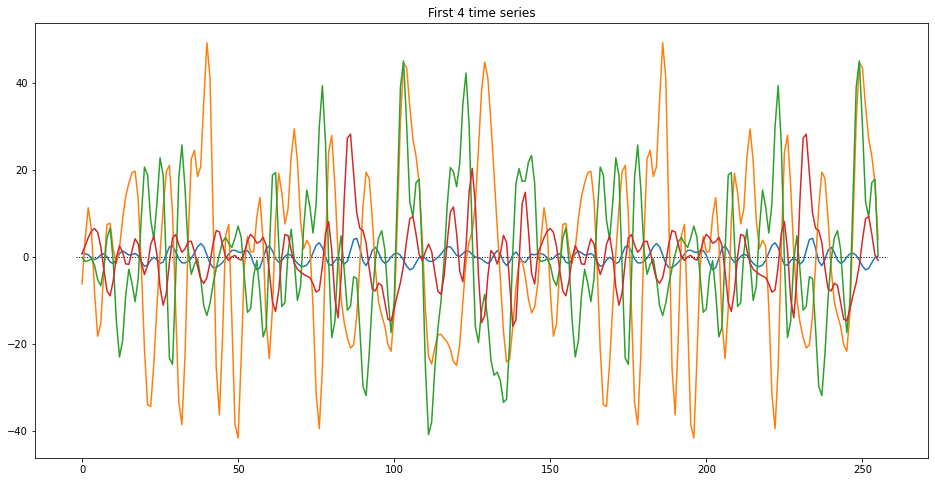

In [ ]:
ts = dataset[0][0]
print(ts.shape)
n_steps = ts.shape[1]
n_rois = 4

plt.figure(figsize=(16, 8))
plt.title(f"First {n_rois} time series")
plt.hlines(0, -2, n_steps + 2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[:n_rois, :].transpose())
plt.show()

In [ ]:
targets_df["SOURCE"]

0       CALTECH
1       CALTECH
2       CALTECH
3       CALTECH
4       CALTECH
         ...   
1106       YALE
1107       YALE
1108       YALE
1109       YALE
1110       YALE
Name: SOURCE, Length: 1111, dtype: object

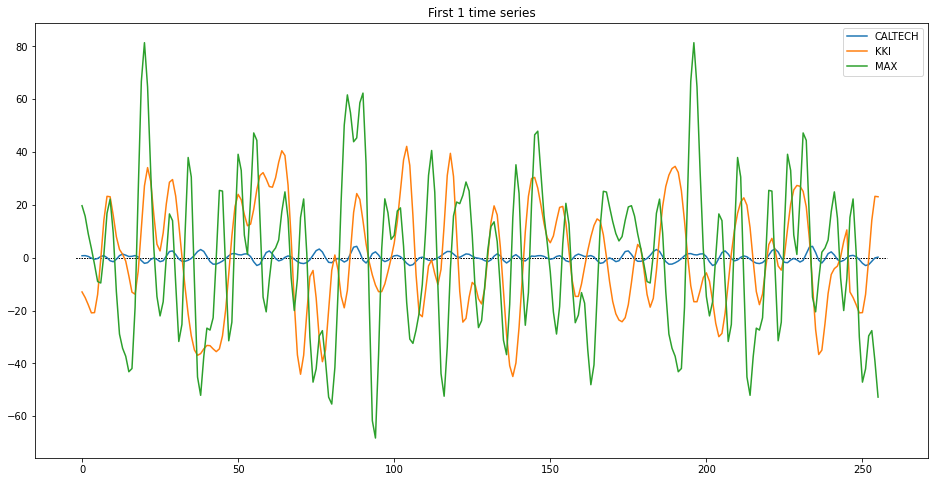

In [ ]:
i = 0
ts = dataset[i][0]
n_steps = ts.shape[1]
n_rois = 1

plt.figure(figsize=(16, 8))
plt.title(f"First {n_rois} time series")
plt.hlines(0, -2, n_steps + 2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[:n_rois, :].transpose(), color="tab:blue", label=targets_df["SOURCE"][i])

i = 100
ts = dataset[i][0]
plt.hlines(0, -2, n_steps + 2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[:n_rois, :].transpose(), color="tab:orange", label=targets_df["SOURCE"][i])

i = 200
ts = dataset[i][0]
plt.hlines(0, -2, n_steps + 2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[:n_rois, :].transpose(), color="tab:green", label=targets_df["SOURCE"][i])
plt.legend()
plt.show()

As can be seen from the plots, data from different acqusition sites also have different standard deviations. 

Thus, it is better to normalize them before traning model. Normalization transform can be impelemented, for example, using the `clean` function from `nilearn`. 

In [ ]:
pip install nilearn

     |████████████████████████████████| 10.0 MB 4.1 MB/s 


In [ ]:
from nilearn.signal import clean

class NormalizeTS(object):
    def __call__(self, data):
        return ### your code here

In [ ]:
# apply normalization transform to time series dataset
dataset.transform = NormalizeTS()

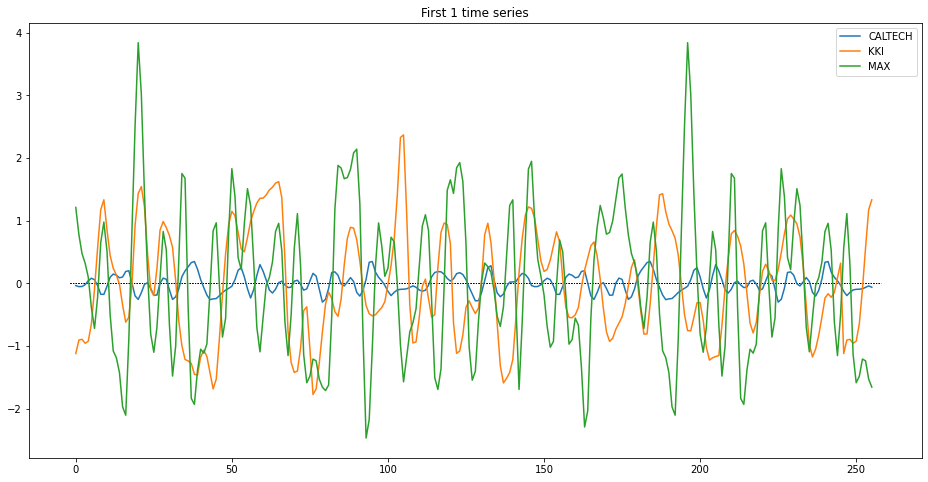

In [ ]:
i = 0
ts = dataset[i][0]
n_steps = ts.shape[1]
n_rois = 1

plt.figure(figsize=(16, 8))
plt.title(f"First {n_rois} time series")
plt.hlines(0, -2, n_steps + 2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[:n_rois, :].transpose(), color="tab:blue", label=targets_df["SOURCE"][i])

i = 100
ts = dataset[i][0]
plt.hlines(0, -2, n_steps + 2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[:n_rois, :].transpose(), color="tab:orange", label=targets_df["SOURCE"][i])

i = 200
ts = dataset[i][0]
plt.hlines(0, -2, n_steps + 2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[:n_rois, :].transpose(), color="tab:green", label=targets_df["SOURCE"][i])
plt.legend()
plt.show()

### Train and utils functions

Here we define functions for training and validation the model. 

In [ ]:
def compute_probs(outputs):
    """
    Computes class probabilities from logits predicted by the model.
    If classification problem is binary, outputs probabilities of the 1st class.
    Else, outputs array of probabilities of each class. 
    """
    if outputs.size(1) <= 2:
        probs = F.softmax(outputs, dim=-1)[:, 1]
    else:
        probs = F.softmax(outputs, dim=-1)
    return probs

def train(train_loader, val_loader, model, opt, scheduler=None, 
          criterion=nn.CrossEntropyLoss(), metric=roc_auc_score,
          n_epochs=100, epsilon=0):
    
    def plot_results(epoch, start_time):
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(train_stats["mean_train_loss"])
        plt.plot(train_stats["mean_val_loss"])
        plt.title("losses")
        plt.subplot(122)
        plt.plot(train_stats["mean_train_metric"])
        plt.plot(train_stats["mean_val_metric"])
        plt.gca().set_ylim([0, 1])
        plt.title("metrics")
        plt.show()
        
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_stats["mean_train_loss"][-1]))
        print("  validation loss: \t\t\t{:.6f}".format(train_stats["mean_val_loss"][-1]))
        print("  training metric: \t\t\t{:.2f}".format(train_stats["mean_train_metric"][-1]))
        print("  validation metric: \t\t\t{:.2f}".format(train_stats["mean_val_metric"][-1]))
    
    train_stats = {
        "mean_train_loss" : [],
        "mean_train_metric" : [],
        "mean_val_loss" : [],
        "mean_val_metric" : [],
    }
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        # train epoch
        model.train(True)
        train_loss, train_preds, train_targets = [], [], []
        for inputs_batch, targets_batch in tqdm(train_loader):
            inputs_batch, targets_batch = inputs_batch.float().to(device), targets_batch.long().to(device)   
            logits_batch = model(inputs_batch)

            loss = criterion(logits_batch, targets_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            train_loss.append(loss.item())
            preds = compute_probs(logits_batch)
            train_preds.extend(list(preds.cpu().data.numpy()))
            train_targets.extend(list(targets_batch.cpu().data.numpy()))
        train_metric = metric(train_targets, train_preds)

        # validate    
        model.train(False)
        val_loss, val_preds, val_targets = [], [], []
        for inputs_batch, targets_batch in tqdm(val_loader):
            inputs_batch, targets_batch = inputs_batch.float().to(device), targets_batch.long().to(device)
            logits_batch = model(inputs_batch)
            
            loss = criterion(logits_batch, targets_batch)

            val_loss.append(loss.item())
            preds = compute_probs(logits_batch)
            val_preds.extend(list(preds.cpu().data.numpy()))
            val_targets.extend(list(targets_batch.cpu().data.numpy()))
        val_metric = metric(val_targets, val_preds)

        if scheduler is not None:
            scheduler.step()
            print("current lr:", scheduler.get_lr()[0])

        # save stats
        train_stats["mean_train_loss"].append(np.mean(train_loss))
        train_stats["mean_train_metric"].append(train_metric)
        train_stats["mean_val_loss"].append(np.mean(val_loss))
        train_stats["mean_val_metric"].append(val_metric)
        
        plot_results(epoch, start_time)
        
        if train_stats["mean_train_loss"][-1] < epsilon:
            break    
    return train_stats

## RNN for multivariate time series

Since the data is essentially a multidimensional time series, it seems natural to try to analyze it with a recurrent neural network. 

### RNN on  ROI time series (with GRU units)

Here we define a general RNN architecture that consists of **1 or more** recurrent layers with GRU units followed by **2** fully connected layers. 

Data is sequentially processed by recurrent layers. Then we take the **last** computed hidden state, **mean** of all hidden states or a vector of **concatenated hidden states**, feed them into fully connected layer and predict the ASD probability. 

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size=116, seq_length=152, n_outputs=2, 
                 hidden_size=128, n_layers=1, dropout_rnn=0.,
                 n_fc_units=128, use_states="last", dropout=0):
        super(self.__class__, self).__init__()
        self.input_size = input_size
        self.seq_length = seq_length
        self.n_outputs = n_outputs
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(
            input_size, 
            hidden_size, n_layers, 
            batch_first=True, # (batch, seq, feature)
            dropout=dropout_rnn,
        )
        
        self.use_states = use_states
        if use_states == "last":
            self.gru_out_size = hidden_size
        elif use_states == "mean":
            self.gru_out_size = hidden_size
        elif use_states == "all":
            self.gru_out_size = hidden_size * seq_length
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(self.gru_out_size, n_fc_units)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(n_fc_units, n_outputs)
        
    def forward(self, x):
        n_objects, n_roi, seq_length = x.size()
        x = x.permute(0, 2, 1) # (batch, seq, feature)
        
        out, _ = self.gru(x)
        
        if self.use_states == "last":
            out = out[:, -1, :]
        elif self.use_states == "mean":
            out = out.mean(dim=1)
        elif self.use_states == "all":
            out = out.reshape(n_objects, self.hidden_size * seq_length)
        
        out = self.dropout(out)
        out = self.fc1(out)  
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

### Training

Split data into training and validation parts, and create **train and val dataloaders**. Then create **GRUModel** with parameters of your choice (don't make it too complex), optimizer and scheduler (if needed). Train the model to detect patients with ASD from healthy control and measure its **ROC AUC** on the validation set. 

You can define a model with arguments of your choice. For example, try to vary `hidden_size`, `n_layers`, `use_states` and `n_fc_units` arguments. However, remember that the training sample is still quite small for DL, and the recurrent network has many parameters, so don't make it too large. 

Also, since ovefitting is very probable, you may want to properly choose `dropout`, `weight_decay` and `n_epochs` values. 

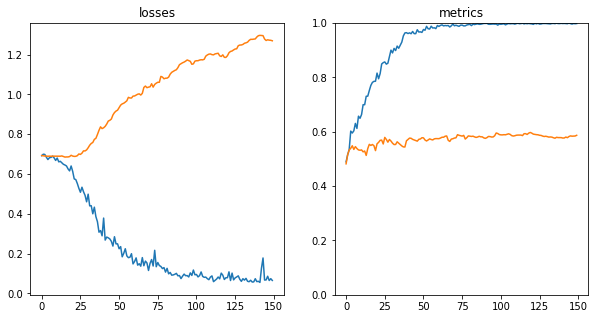

Epoch 150 of 150 took 1.344s
  training loss (in-iteration): 	0.065468
  validation loss: 			1.269123
  training metric: 			1.00
  validation metric: 			0.59


In [ ]:
# use data from all sources
dataset.use_sources = []

# dataset have target classes 1 and 2
# encode target with LabelEncoder to use classes 0 and 1 instead
dataset.set_target("DX_GROUP", encode_target=True)

# we need to convert training data to torch.Tensor
dataset.transform = ToTensor()

notnull_idx = dataset.target[dataset.target.notnull()].index
train_idx, val_idx = train_test_split(notnull_idx, stratify=dataset.target[notnull_idx],
                                      test_size=0.2, random_state=42)
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

model = GRUModel(
    input_size=200, # number of rois
    seq_length=256,
    n_outputs=2, 
    hidden_size=16,
    n_layers=1,
    use_states="mean",
    n_fc_units=32,
    dropout=0.3,
).to(device)  
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.5)

train_stats = train(train_loader, val_loader, model, opt, scheduler, 
                    criterion=nn.CrossEntropyLoss(), metric=roc_auc_score,
                    n_epochs=150)

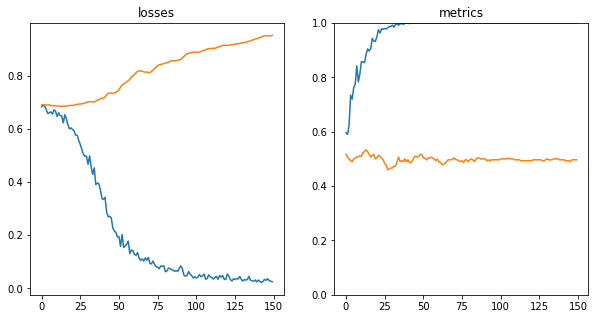

Epoch 150 of 150 took 0.584s
  training loss (in-iteration): 	0.024815
  validation loss: 			0.953054
  training metric: 			1.00
  validation metric: 			0.50


In [ ]:
# for comparison, train on the data from a single acquisition site
dataset.use_sources = ["NYU"]

# dataset have target classes 1 and 2
# encode target with LabelEncoder to use classes 0 and 1 instead
dataset.set_target("DX_GROUP", encode_target=True)

# we need to convert training data to torch.Tensor
dataset.transform = ToTensor()

notnull_idx = dataset.target[dataset.target.notnull()].index
train_idx, val_idx = train_test_split(notnull_idx, stratify=dataset.target[notnull_idx],
                                      test_size=0.2, random_state=42)
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

model = GRUModel(
    input_size=200, # number of rois
    seq_length=256,
    n_outputs=2, 
    hidden_size=16,
    n_layers=1,
    use_states="mean",
    n_fc_units=32,
    dropout=0.2,
).to(device)  
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.5)

train_stats = train(train_loader, val_loader, model, opt, scheduler, 
                    criterion=nn.CrossEntropyLoss(), metric=roc_auc_score,
                    n_epochs=150)